# Conectando com o Banco de Dados

In [4]:
import psycopg2
import os
import json

# Load the database parameters
db_params_path = os.path.join("scripts", "db_params.json")
with open(db_params_path, "r") as f:
    db_params = json.load(f)

# Establish a connection
connection = psycopg2.connect(**db_params)

## Teste

In [5]:
import pandas as pd

n = 0

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

# Take a look at the data
df.describe()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/808633263.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


,problem_id,count
count,138.000000,138.000000
mean,678.195652,369.673913
std,268.866718,539.780872
min,3.000000,1.000000
25%,743.250000,4.000000
50%,783.500000,20.000000
75%,818.750000,893.750000
max,857.000000,1813.000000


# Análise Exploratória

## Quantas questões existem no banco de dados?

In [6]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_problem
                """

# Load data into a Pandas dataframe
questions_df = pd.read_sql_query(sql_query, connection)

# Count lines
questions_df.count()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/593237104.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  questions_df = pd.read_sql_query(sql_query, connection)


id                     842
title                  842
content                842
difficulty             842
link                   842
retrieved_date         842
crawler                842
hint                   842
test_case_generator    124
question_type          842
options                842
dtype: int64

### Quantas questões com resposta existem no banco de dados?

In [7]:
n = 1

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

print(f"Number of problems with at least {n} answer(s) from distinct users: {len(df)}")

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/650427698.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


Number of problems with at least 1 answer(s) from distinct users: 138


## Quantas soluções existem no banco de dados?

Transformando tabela de soluções em Dataframe:

In [8]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_userlog
                """

# Load data into a Pandas dataframe
solutions_df = pd.read_sql_query(sql_query, connection)

solutions_df.describe()


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/3692574933.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solutions_df = pd.read_sql_query(sql_query, connection)


,id,seconds_in_code,seconds_in_page,seconds_to_begin,solution_lines,problem_id,user_id,test_case_hits,user_class_id
count,434337.000000,4.343370e+05,434337.000000,434337.000000,434337.000000,434337.000000,434337.000000,426418.000000,434337.000000
mean,351012.579948,8.547523e+02,2805.806567,335.728480,11.139997,803.728800,1843.444443,26.622722,69.952010
std,125402.352557,8.804527e+03,12750.494749,3536.405048,9.153649,52.135296,632.069444,39.219658,27.920784
min,84420.000000,0.000000e+00,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,2.000000
25%,242438.000000,9.200000e+01,314.000000,3.000000,7.000000,804.000000,1323.000000,0.000000,54.000000
50%,351023.000000,1.940000e+02,796.000000,15.000000,10.000000,813.000000,1762.000000,0.000000,73.000000
75%,459607.000000,3.900000e+02,1885.000000,79.000000,14.000000,827.000000,2348.000000,53.000000,88.000000
max,568191.000000,1.042544e+06,504133.000000,499615.000000,3859.000000,857.000000,3421.000000,100.000000,143.000000


In [9]:
solutions_count = len(solutions_df)
print(f"Number of solutions: {solutions_count}")

Number of solutions: 434337


## Quantas são as soluções sem contar as tentativas repetidas em cada questão?

Contamos apenas a última solução submetida por um usuário para cada questão.

Em outras palavras, queremos o número de soluções com pares únicos de [problem_id, user_id].

In [10]:
# Count number of solutions with unique problem_id/user_id pairs 

unique_solutions_count = len(solutions_df.groupby(["problem_id", "user_id"]))
print(f"Number of unique solutions: {unique_solutions_count}")
percentage = round(unique_solutions_count/solutions_count * 100, 1)
print(f"Counting only unique solutions, we need look just at {percentage}% of the solutions.")

Number of unique solutions: 51015
Counting only unique solutions, we need look just at 11.7% of the solutions.


## Quais são as estatísticas das soluções únicas?

Gerando um dataframe de soluções únicas

In [11]:
# Sort the solutions dataframe by 'user_id' and 'problem_id' and 'timestamp' in descending order
sorted_solutions_df = solutions_df.sort_values(by=['user_id', 'problem_id', 'timestamp'], ascending=[True, True, True])

# Use groupby to group by 'user_id' and 'problem_id' and select the last solution in each group
last_solution_df = sorted_solutions_df.groupby(['user_id', 'problem_id']).last().reset_index()

In [12]:
last_solution_df.describe()

,user_id,problem_id,id,seconds_in_code,seconds_in_page,seconds_to_begin,solution_lines,test_case_hits,user_class_id
count,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,50029.000000,51015.000000
mean,1829.338528,799.172734,351632.839655,506.568735,1785.642635,334.944036,11.333392,93.099083,69.161756
std,656.720386,63.597801,128877.753572,7900.330112,10297.295393,4604.079000,6.793658,24.535300,29.301950
min,1.000000,3.000000,84427.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
25%,1266.000000,800.000000,235979.500000,42.000000,137.000000,3.000000,7.000000,100.000000,38.000000
50%,1715.000000,815.000000,351300.000000,126.000000,443.000000,13.000000,10.000000,100.000000,73.000000
75%,2355.000000,828.000000,464049.000000,251.000000,1150.000000,65.000000,14.000000,100.000000,88.000000
max,3421.000000,857.000000,568191.000000,940115.000000,504133.000000,499615.000000,123.000000,100.000000,143.000000


#

## Quantos são os alunos no banco de dados?

In [13]:
# TODO cortar os usuarios que são staff ou não estao ativos

# SQL query
sql_query = f"""SELECT id
                FROM auth_user
                """

# Load data into a Pandas dataframe
students_df = pd.read_sql_query(sql_query, connection)

# Count lines
print(f"Number of users: {len(students_df)}")

Number of users: 3162


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/3031740989.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  students_df = pd.read_sql_query(sql_query, connection)


## Como é o histograma do número de soluções por questão?

In [15]:
sols_per_question = last_solution_df.groupby(['problem_id'])['id'].count()
print(f"Number of questions with solutions: {len(sols_per_question)}")

Number of questions with solutions: 138


### Histograma Original

In [16]:
import matplotlib
import matplotlib.pyplot as plt

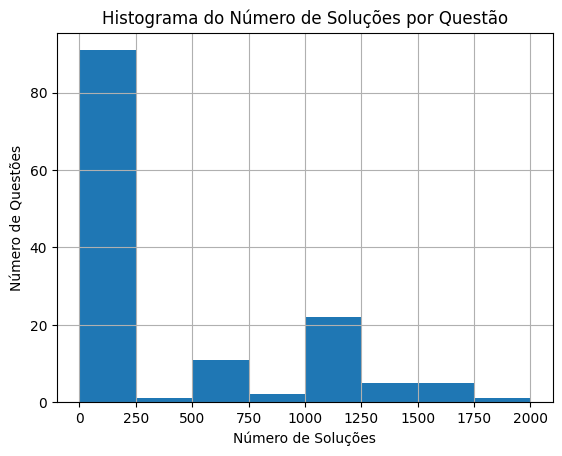

In [49]:
sols_per_question.hist(bins=range(0, 2001, 250))

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma do Número de Soluções por Questão')

# Show the histogram
plt.show()

### Avaliando questões com poucas soluções (<= 50)

Number of questions with less than 250 solutions: 91


Text(0.5, 1.0, 'Histograma Soluções por Questão (< 250 soluções)')

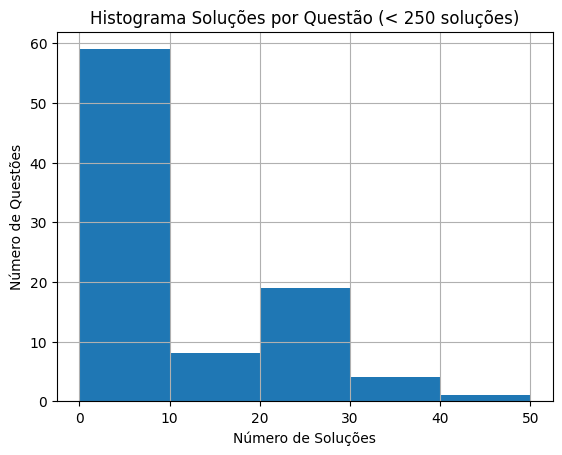

In [47]:
few_sols_series = sols_per_question[sols_per_question < 250]
few_sols_series.hist(bins=range(0, 51, 10))

print(f"Number of questions with less than 250 solutions: {len(few_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (< 250 soluções)')

### Questões com apenas 1 solução (não são interessantes para o Overcode)

In [51]:
one_sol_series = sols_per_question[sols_per_question == 1]
print(f"Number of questions with only one solution: {len(one_sol_series)}")

Number of questions with only one solution: 14


### Avaliando questões com muitas soluções (> 250)

Number of questions with more than 250 solutions: 47


Text(0.5, 1.0, 'Histograma Soluções por Questão (> 250 soluções)')

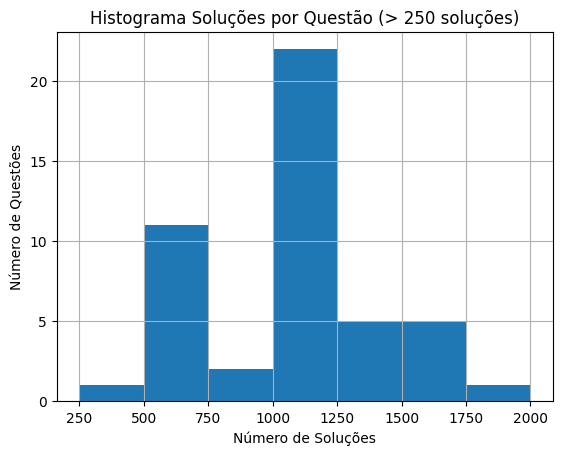

In [50]:
many_sols_series = sols_per_question[sols_per_question > 250]
many_sols_series.hist(bins=range(250, 2001, 250))

print(f"Number of questions with more than 250 solutions: {len(many_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (> 250 soluções)')

# Análise dos Dados do Overcode

## Teste com Problema 737

### Coletar dados do Machine Teaching e processar com Overcode

In [61]:
from master_script import run_master_script

problem_id = 737

run_master_script(737, interface=False)

Master script finished running for problem 737.


### Analisar output do Overcode

In [70]:
df_test = pd.read_json(f"problems_data/problem_{problem_id}/output/solutions.json")
df_test.head()

,correct,count,error_vector,id,lineIDs,lines,members,num_passed_tests,number,phraseIDs,stack_distances,test_input_outputs,testcases,total_num_tests,variableIDs
0,True,6,"[True, True, True, True, True, True, True, Tru...",1,"{'list': [1, 2, 3], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...","[1528, 1526, 1465, 2815, 1529, 1190]",50,1528,"[1, 2, 3]","{'1': 1.0, '2': 0.47500000000000003, '3': 0.83...","{'print(sorte(""Aid\u00e9e"", 10, 2004))': 'Para...","[print(sorte(""Jaime"", 56, 1982)), print(sorte(...",50,"[1, 2, 3, 4]"
1,True,1,"[True, True, True, True, True, True, True, Tru...",2,"{'list': [1, 4, 5, 6, 7, 8, 9], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...",[2954],50,2954,"[1, 4, 5, 6, 7, 8, 9]","{'1': 0.47500000000000003, '2': 1.0, '3': 0.47...","{'print(sorte(""Aid\u00e9e"", 10, 2004))': 'Para...","[print(sorte(""Jaime"", 56, 1982)), print(sorte(...",50,"[1, 3, 4, 5]"
2,True,6,"[True, True, True, True, True, True, True, Tru...",3,"{'list': [1, 2, 10], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...","[1434, 1425, 1464, 1489, 1497, 973]",50,1434,"[1, 2, 10]","{'1': 0.833333333333333, '2': 0.47500000000000...","{'print(sorte(""Aid\u00e9e"", 10, 2004))': 'Para...","[print(sorte(""Jaime"", 56, 1982)), print(sorte(...",50,"[1, 2, 3, 4]"
3,True,1,"[True, True, True, True, True, True, True, Tru...",4,"{'list': [1, 4, 5, 8, 9, 11, 12], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...",[3397],50,3397,"[11, 12, 13, 14, 15, 16, 17]","{'1': 0.28571428571428503, '2': 0.285714285714...","{'print(sorte(""Aid\u00e9e"", 10, 2004))': 'Para...","[print(sorte(""Jaime"", 56, 1982)), print(sorte(...",50,"[1, 4, 6]"
4,True,1,"[True, True, True, True, True, True, True, Tru...",5,"{'list': [1, 13], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...",[2809],50,2809,"[1, 18]","{'1': 0.628571428571428, '2': 0.53968253968253...","{'print(sorte(""Aid\u00e9e"", 10, 2004))': 'Para...","[print(sorte(""Jaime"", 56, 1982)), print(sorte(...",50,"[1, 3, 4]"


#### Quantidade de Soluções e Soluções Corretas

In [80]:
total_solutions = sum(df_test['count'])
print(f"Number of solutions: {total_solutions}")

Number of solutions: 35


In [104]:
correct_solutions = df_test[df_test['correct'] == True]['count'].sum()
print(f"Number of correct solutions: {correct_solutions}")
print(f"Number of incorrect solutions: {total_solutions - correct_solutions}")

Number of correct solutions: 33
Number of incorrect solutions: 2


#### Histograma dos clusters de soluções

Text(0.5, 1.0, 'Histograma Soluções X Cluster')

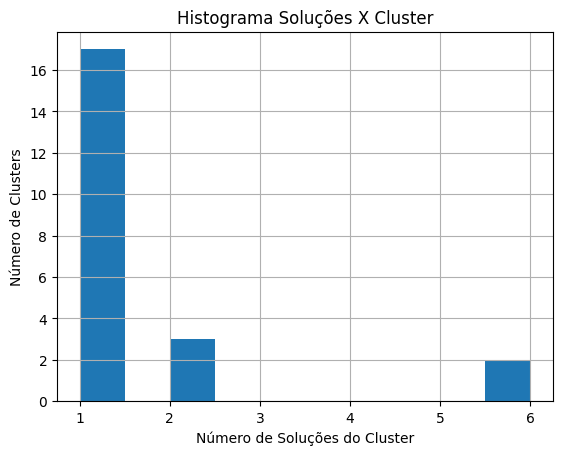

In [111]:
df_test['count'].hist()
# Add labels and a title
plt.xlabel('Número de Soluções do Cluster')
plt.ylabel('Número de Clusters')
plt.title('Histograma Soluções X Cluster')

#### Verificação da Regra de Pareto